# Animation notebook

This notebook offers a simple way of visualizing the motion of the individuals on the two dimensional lattice duting the simulation.\
It's also possible to save the the animation in *MP4* format by running the last code cell.

In [1]:
import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.animation import FuncAnimation

import src.ga_utils as ga
from src.individual import generate_population

In [2]:
# Simulation parameters
D = 40
n_individuals = 50
moves = 15
max_generations = 50
init_energy = 40
food_fraction = 0.4
poison_fraction = 0.2
p_mutation = 0.05
seed = 20

In [3]:
def main_for_animation(
    D: int,
    n_individuals: int,
    moves: int,
    max_generations: int,
    init_energy: int,
    food_fraction: float,
    poison_fraction: float,
    p_mutation: float,
    seed: int,
):

    """
        Main function - Develop survival instinct in a population using Genetic Algorithms (version for animation).
    """

    # Check if grid is near saturation and print warning
    grid_sat = food_fraction + poison_fraction
    if grid_sat >= 1:
        raise ValueError (
            "Grid over-saturated with poison and food.",
            f"Note thah 'food_fraction + poison_fraction' must be less that 1, but {grid_sat} was given.")
    elif grid_sat >= 0.85:
        print("\nWARNING: Grid near saturation. Computation could be slow!") 


    agg_posx, agg_posy = [], []
    agg_grid = []
    
    # Init rng
    random.seed(seed)
    
    # Init grid and population
    grid = np.zeros((D,D), dtype=np.short)
    ga.distribute_food(grid, food_fraction)
    ga.distribute_poison(grid, poison_fraction)

    population = generate_population(n_individuals, init_energy, moves, D)

    pos_x = [ind.x for ind in population]
    pos_y = [ind.y for ind in population]

    # Run genetic algorithm
    index_generations = 0
    lc, lp, ln = [], [], []

    while ga.is_population_alive(population) and index_generations < max_generations:
        lc.append(ga.learning_percentage(population))
        lp.append(ga.poison_percentage(population))
        ln.append(ga.neutral_percentage(population))

        for step in range(moves):
            for ind in population:
                ind.move(grid)
            
            pos_x = [ind.x for ind in population]
            pos_y = [ind.y for ind in population]
            agg_posx.append(pos_x.copy())
            agg_posy.append(pos_y.copy())
            agg_grid.append(grid.copy())            


        # Generate new population and update food/poison distribution
        population = ga.update_population(population, p_mutation)
        ga.distribute_food(grid, food_fraction)
        ga.distribute_poison(grid, poison_fraction)
        
        index_generations += 1
        

    # Print final results
    print("Initial learning percentage: {:.1f}".format(lc[0]))
    print("Final learning percentage: {:.1f}".format(lc[-1]))
    print("Initial poison percentage: {:.1f}".format(lp[0]))
    print("Final poison percentage: {:.1f}".format(lp[-1]))
    print("After", index_generations, "new generations")
    
    return agg_posx, agg_posy, agg_grid, lc, lp, ln


# Updating function, to be repeatedly called by the animation
def update(step, scatter, image, ax, x, y, g):
    scatter.set_offsets(np.array((y[step], x[step])).T)
    image.set_data(g[step])
    display.display(plt.gcf())
    display.clear_output(wait=True)

    return ax

In [4]:
agg_posx, agg_posy, agg_grid, lc, lp, ln = main_for_animation(
    D=D,
    n_individuals=n_individuals,
    moves=moves,
    max_generations=max_generations,
    init_energy=init_energy,
    food_fraction=food_fraction,
    poison_fraction=poison_fraction,
    p_mutation=p_mutation,
    seed=seed
)

Initial learning percentage: 31.3
Final learning percentage: 84.8
Initial poison percentage: 36.4
Final poison percentage: 9.1
After 50 new generations


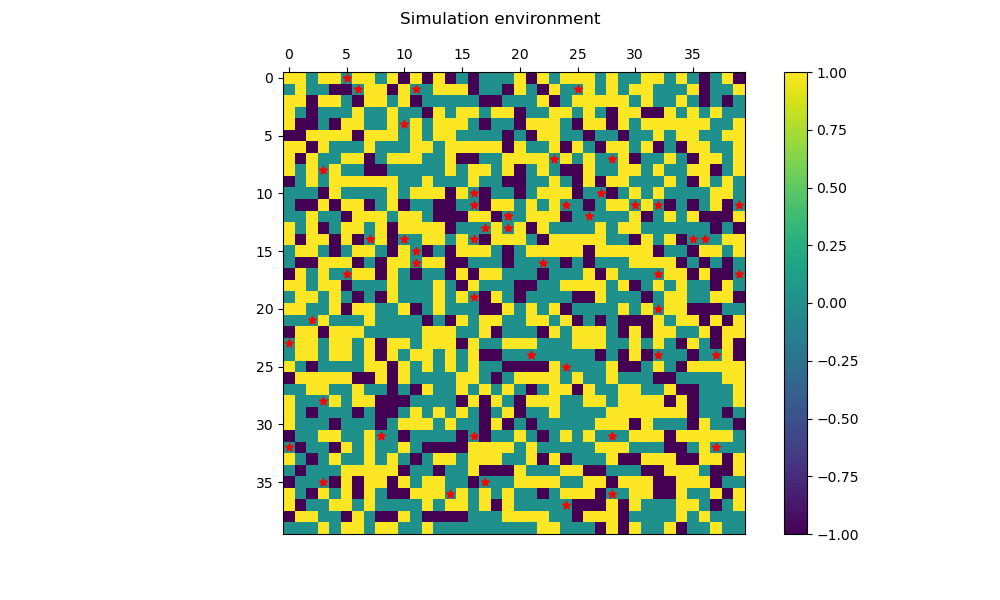

In [5]:
%matplotlib ipympl

fig, ax = plt.subplots(1,1,figsize=(10,6))
fig.suptitle('Simulation environment', fontsize=12)
sc = ax.scatter(agg_posy[0], agg_posx[0], color='red', marker='*')
im = ax.imshow(agg_grid[0])
fig.colorbar(im, ax=ax)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
ax.invert_yaxis();

animation = FuncAnimation(
    fig, 
    partial(update, x=agg_posx, y=agg_posy, g=agg_grid, scatter=sc, image=im, ax=ax),
    interval=200, repeat=False, blit=True, frames=len(agg_grid)
)

# Show animation
plt.show()

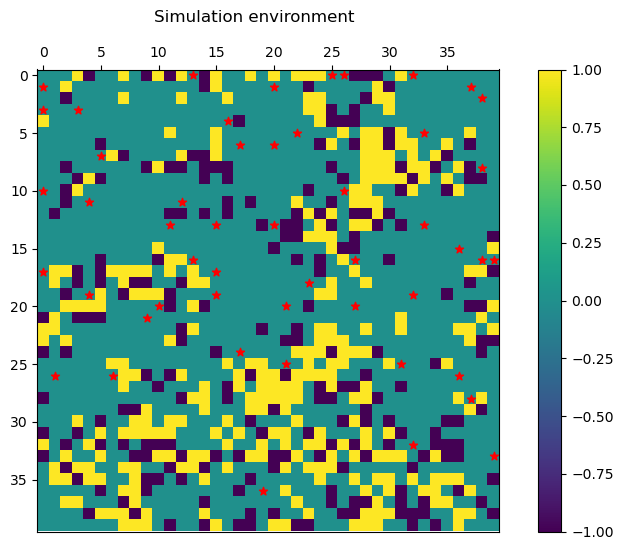

In [6]:
# Save animations
animation.save('images/animation.mp4');